In [1]:
from src.model import VAE
from src.losses import divergence_fn
import torch
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
import numpy as np

from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


In [2]:
from corruption_utils import corruptions

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
%%capture
mnist = torchvision.datasets.MNIST("../data", train=True, download=True)

In [5]:
class MNISTPairGenerator:
    def __init__(
        self, dataset: torchvision.datasets.MNIST, p: float, corruption_fns: None | dict
    ) -> None:
        label_dict = dict()
        for i in range(10):
            label_dict[i] = torch.where(dataset.train_labels == i)[0]
        self.dataset = dataset
        self.corruption_fns = corruption_fns
        self.p = p
        self.label_dict = label_dict

    def __getitem__(self, index):
        base_img, target = self.dataset[index]
        pair_content_label = np.random.binomial(1, self.p)
        if pair_content_label == 0:  # matched
            pair_img_idx = np.random.choice(self.label_dict[target], size=1)[0]
        else:  # unmatched
            unmatched_idx = torch.where(self.dataset.train_labels != target)[0]
            pair_img_idx = np.random.choice(unmatched_idx, size=1)[0]

        if self.corruption_fns is not None:
            base_cfn = np.random.choice(
                list(self.corruption_fns.keys()), p=list(self.corruption_fns.values())
            )
            pair_cfn = np.random.choice(
                list(self.corruption_fns.keys()), p=list(self.corruption_fns.values())
            )
        
            pair_style_label = 0 if base_cfn == pair_cfn else 1
        else:
            pair_style_label = 0

        pair_img, _ = self.dataset[pair_img_idx]
        return base_cfn(base_img), pair_cfn(pair_img), pair_content_label, pair_style_label

    @property
    def size(self):
        return len(self.dataset)


class PairDataset(Dataset):
    """
    Dataset object based on a pair generator.
    """

    def __init__(self, generator, transform):
        self.generator = generator
        self.transform = transform
        self.N = generator.size
        self.dataset = [None] * self.N
        with tqdm(range(self.N), unit="item") as bar:
            bar.set_description("Generating dataset")
            for i in bar:
                self.dataset[i] = self.generator[i]

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        img1, img2, content_label, style_label = self.dataset[idx]
        img1, img2 = self.transform(img1), self.transform(img2)
        return img1, img2, content_label, style_label

    def display(self, idx):
        img1, img2, content_label, style_label = self.__getitem__(idx)
        print(f"content label: {int(content_label)}, style label: {style_label}")
        display(transforms.ToPILImage()(img1), transforms.ToPILImage()(img2))


In [6]:
generator = MNISTPairGenerator(
    mnist,
    0.5,
    {
        corruptions.identity: 0.3,
        corruptions.stripe: 0.3,
        corruptions.zigzag: 0.3,
        corruptions.canny_edges: 0.1,
    },
)


In [7]:
dataset = PairDataset(
    generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)


Generating dataset: 100%|██████████| 60000/60000 [00:29<00:00, 2046.04item/s]


In [36]:
dataset.display(0)
dataset.display(1)
dataset.display(2)
dataset.display(4)

content label: 0, style label: 1


content label: 1, style label: 0


content label: 1, style label: 1


content label: 1, style label: 1


## Supervised

In [20]:
from src.trainer import CDTrainer

In [37]:
vae = VAE(z_dim=16).to(device)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
trainer = CDTrainer(vae, optimizer, verbose_period=5, fully_supervised=True, device=device)

In [38]:
trainer.fit(dataloader, 21)

Epoch 20: 100%|██████████| 469/469 [00:06<00:00, 73.25batch/s, contrastive_c=4.41, contrastive_s=3.55, vae_b_loss=15.4, vae_p_loss=13.6]


### test result

In [39]:
%%capture
vae.eval()

In [40]:
vae.training

False

In [41]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
Xb, Xp, label_c, label_s = next(iter(dataloader))
Xb = Xb.to(device)
Xp = Xp.to(device)
label_c = label_c.to(device)
label_s = label_s.to(device)

In [42]:
Xb_hat, latent_params_b, z_b = vae(Xb, explicit=True)
Xp_hat, latent_params_p, z_p = vae(Xp, explicit=True)

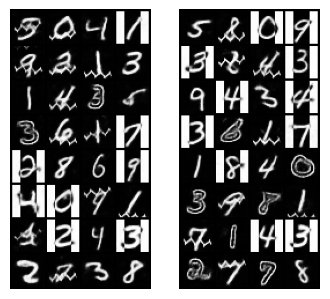

tensor([[12.7900, 22.6800, 22.3700, 21.3600],
        [11.6500, 14.3800, 15.5200, 13.1200],
        [22.0500,  4.5900, 13.7500, 10.7000],
        [ 5.7200, 14.5100,  9.5200,  2.8400],
        [18.3800,  4.8400, 13.3800, 22.4300],
        [22.8900, 23.3800, 11.8900,  3.5400],
        [20.7600, 22.2700,  5.0900,  3.7800],
        [13.9600,  7.9300, 12.3600,  8.1200]], device='cuda:0')
tensor([[0, 1, 1, 1],
        [1, 0, 1, 0],
        [1, 0, 0, 1],
        [0, 0, 0, 0],
        [1, 0, 1, 1],
        [1, 1, 1, 0],
        [1, 1, 0, 0],
        [0, 0, 1, 0]], device='cuda:0')
tensor([[31.1900,  8.9500, 54.3600,  4.3600],
        [40.2100, 12.9300,  6.4500, 53.9600],
        [ 8.4500, 36.4900, 56.5900, 62.7300],
        [68.3000, 67.9000, 11.3200, 11.0600],
        [61.7900, 68.9900, 10.8800, 72.0300],
        [86.5300, 33.5900, 56.3100,  3.8200],
        [13.7100, 92.9400, 51.5400,  5.9900],
        [49.9300, 17.3400, 57.7900, 19.6600]], device='cuda:0')
tensor([[1, 0, 1, 0],
        [1, 

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(4, 4))
axs[0].imshow(make_grid(Xb_hat, nrow=4).cpu().permute(1, 2, 0))
axs[0].axis("off")
axs[1].imshow(make_grid(Xp_hat, nrow=4).cpu().permute(1, 2, 0))
axs[1].axis("off")
plt.show()
torch.set_printoptions(sci_mode=False)
with torch.no_grad():
    print(
        divergence_fn(
            latent_params_b["mu_c"],
            latent_params_p["mu_c"],
            latent_params_b["logvar_c"],
            latent_params_p["logvar_c"],
        )
        .reshape(-1, 4)
        .round(decimals=2)
    )
    print(label_c.reshape(-1, 4))

    print(
        divergence_fn(
            latent_params_b["mu_s"],
            latent_params_p["mu_s"],
            latent_params_b["logvar_s"],
            latent_params_p["logvar_s"],
        )
        .reshape(-1, 4)
        .round(decimals=2)
    )
    print(label_s.reshape(-1, 4))

In [181]:
from src.model import interpolate_latent

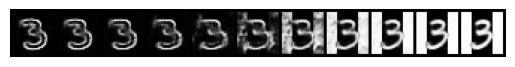

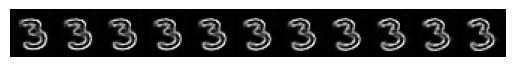

In [44]:
with torch.no_grad():
    idx = 12
    z1, z2 = z_b[idx], z_p[idx]
    display(transforms.ToPILImage()(vae.decode(z1.view(1, -1))[0]))
    display(transforms.ToPILImage()(vae.decode(z2.view(1, -1))[0]))

    z_inter = interpolate_latent(latent1=z1[16:], latent2=z2[16:], num_steps=11, device=device)
    z_combined = torch.cat([z1[:16][None, :].repeat(11, 1), z_inter], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

    z_inter = interpolate_latent(latent1=z1[:16], latent2=z2[:16], num_steps=11, device=device)
    z_combined = torch.cat([z_inter, z1[16:][None, :].repeat(11, 1)], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

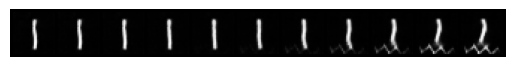

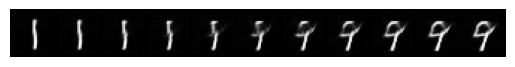

In [45]:
with torch.no_grad():
    idx = 8
    z1, z2 = z_b[idx], z_p[idx]
    display(transforms.ToPILImage()(vae.decode(z1.view(1, -1))[0]))
    display(transforms.ToPILImage()(vae.decode(z2.view(1, -1))[0]))

    z_inter = interpolate_latent(latent1=z1[16:], latent2=z2[16:], num_steps=11, device=device)
    z_combined = torch.cat([z1[:16][None, :].repeat(11, 1), z_inter], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

    z_inter = interpolate_latent(latent1=z1[:16], latent2=z2[:16], num_steps=11, device=device)
    z_combined = torch.cat([z_inter, z1[16:][None, :].repeat(11, 1)], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()


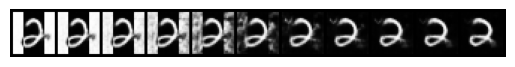

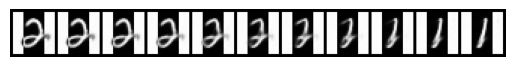

In [46]:
with torch.no_grad():
    idx = 16
    z1, z2 = z_b[idx], z_p[idx]
    display(transforms.ToPILImage()(vae.decode(z1.view(1, -1))[0]))
    display(transforms.ToPILImage()(vae.decode(z2.view(1, -1))[0]))

    z_inter = interpolate_latent(latent1=z1[16:], latent2=z2[16:], num_steps=11, device=device)
    z_combined = torch.cat([z1[:16][None, :].repeat(11, 1), z_inter], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

    z_inter = interpolate_latent(latent1=z1[:16], latent2=z2[:16], num_steps=11, device=device)
    z_combined = torch.cat([z_inter, z1[16:][None, :].repeat(11, 1)], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()


## Unsupervised

In [24]:
vae = VAE(z_dim=16).to(device)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
trainer = CDTrainer(vae, optimizer, verbose_period=5, fully_supervised=False, device=device)

In [25]:
trainer.fit(dataloader, 21)

Epoch 20: 100%|██████████| 469/469 [00:05<00:00, 78.21batch/s, contrastive_c=2.61, contrastive_s=0, vae_b_loss=13.3, vae_p_loss=13.3]


### test result

In [26]:
%%capture
vae.eval()

In [27]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
Xb, Xp, label_c, label_s = next(iter(dataloader))
Xb = Xb.to(device)
Xp = Xp.to(device)
label_c = label_c.to(device)
label_s = label_s.to(device)

In [28]:
Xb_hat, latent_params_b, z_b = vae(Xb, explicit=True)
Xp_hat, latent_params_p, z_p = vae(Xp, explicit=True)

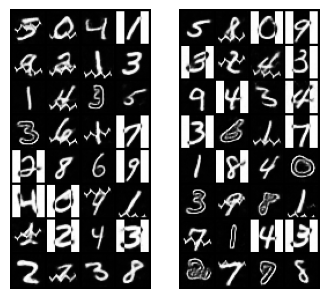

tensor([[ 7.5700, 13.8700, 15.5700, 24.7600],
        [17.0100, 13.9100,  9.9300,  4.7100],
        [15.7000,  2.2600,  5.8900, 13.7000],
        [ 4.4400, 11.8100,  2.7500,  1.3800],
        [16.0700,  4.8600, 12.2500, 15.5200],
        [14.3900, 15.6400,  9.8800,  0.8100],
        [18.1100, 21.0400,  1.2000,  1.5500],
        [11.9600,  6.5900, 11.3700,  5.4400]], device='cuda:0')
tensor([[0, 1, 1, 1],
        [1, 0, 1, 0],
        [1, 0, 0, 1],
        [0, 0, 0, 0],
        [1, 0, 1, 1],
        [1, 1, 1, 0],
        [1, 1, 0, 0],
        [0, 0, 1, 0]], device='cuda:0')
tensor([[247.5600, 169.1300, 234.7600,  79.0500],
        [338.6900, 234.3500, 135.0900, 243.2500],
        [ 67.8600, 270.4400, 444.4200, 170.3900],
        [505.3600, 337.8000, 173.6200, 102.8600],
        [148.0300, 191.2300, 140.3500, 519.6700],
        [617.2800, 280.0400, 272.6200,  50.4000],
        [245.3000, 431.9800, 103.0900,  98.7700],
        [665.8300, 203.4800, 485.9900, 287.8600]], device='cuda:0')
te

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(4, 4))
axs[0].imshow(make_grid(Xb_hat, nrow=4).cpu().permute(1, 2, 0))
axs[0].axis("off")
axs[1].imshow(make_grid(Xp_hat, nrow=4).cpu().permute(1, 2, 0))
axs[1].axis("off")
plt.show()
torch.set_printoptions(sci_mode=False)
with torch.no_grad():
    print(
        divergence_fn(
            latent_params_b["mu_c"],
            latent_params_p["mu_c"],
            latent_params_b["logvar_c"],
            latent_params_p["logvar_c"],
        )
        .reshape(-1, 4)
        .round(decimals=2)
    )
    print(label_c.reshape(-1, 4))

    print(
        divergence_fn(
            latent_params_b["mu_s"],
            latent_params_p["mu_s"],
            latent_params_b["logvar_s"],
            latent_params_p["logvar_s"],
        )
        .reshape(-1, 4)
        .round(decimals=2)
    )
    print(label_s.reshape(-1, 4))

In [30]:
from src.model import interpolate_latent

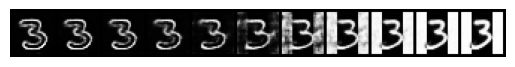

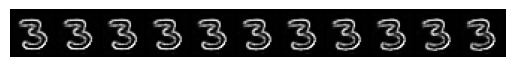

In [31]:
with torch.no_grad():
    idx = 12
    z1, z2 = z_b[idx], z_p[idx]
    display(transforms.ToPILImage()(vae.decode(z1.view(1, -1))[0]))
    display(transforms.ToPILImage()(vae.decode(z2.view(1, -1))[0]))

    z_inter = interpolate_latent(latent1=z1[16:], latent2=z2[16:], num_steps=11, device=device)
    z_combined = torch.cat([z1[:16][None, :].repeat(11, 1), z_inter], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

    z_inter = interpolate_latent(latent1=z1[:16], latent2=z2[:16], num_steps=11, device=device)
    z_combined = torch.cat([z_inter, z1[16:][None, :].repeat(11, 1)], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()


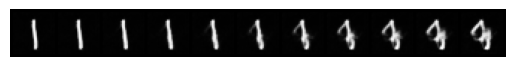

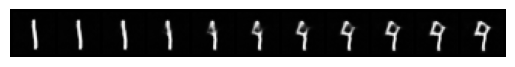

In [32]:
with torch.no_grad():
    idx = 8
    z1, z2 = z_b[idx], z_p[idx]
    display(transforms.ToPILImage()(vae.decode(z1.view(1, -1))[0]))
    display(transforms.ToPILImage()(vae.decode(z2.view(1, -1))[0]))

    z_inter = interpolate_latent(latent1=z1[16:], latent2=z2[16:], num_steps=11, device=device)
    z_combined = torch.cat([z1[:16][None, :].repeat(11, 1), z_inter], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

    z_inter = interpolate_latent(latent1=z1[:16], latent2=z2[:16], num_steps=11, device=device)
    z_combined = torch.cat([z_inter, z1[16:][None, :].repeat(11, 1)], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()


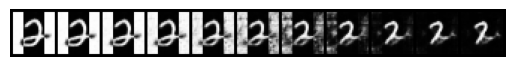

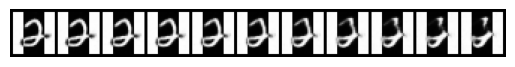

In [33]:
with torch.no_grad():
    idx = 16
    z1, z2 = z_b[idx], z_p[idx]
    display(transforms.ToPILImage()(vae.decode(z1.view(1, -1))[0]))
    display(transforms.ToPILImage()(vae.decode(z2.view(1, -1))[0]))

    z_inter = interpolate_latent(latent1=z1[16:], latent2=z2[16:], num_steps=11, device=device)
    z_combined = torch.cat([z1[:16][None, :].repeat(11, 1), z_inter], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

    z_inter = interpolate_latent(latent1=z1[:16], latent2=z2[:16], num_steps=11, device=device)
    z_combined = torch.cat([z_inter, z1[16:][None, :].repeat(11, 1)], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()
